In [66]:
"""
PAIR003 - Navarasam (Thaikkudam Bridge) vs. Varaha Roopam (Kantara)
------------------------------------------------------------------
Purpose: 
    1. Quantify how strongly the original and derived tracks co-move in visibility. 
    2. Check whether Spotify and YT dynamics behave similarly (trend-wise). 
Method: 
    1. Pearson correlation test (linear dependence)
    2. Spearman rank correlation test (robust to outliers, also nonlinear!)
    3. I will log-transform YT views (to handle any potential skew). 
    4. Here, I will also conduct cross-platform analysis (since the original's YT data isn't available)s
Possible Interpretation:
    1. High r -> shared visibility trajectory (possible spillover)
    2. Low r -> platform divergence or other rationale. 
"""

"\nPAIR003 - Navarasam (Thaikkudam Bridge) vs. Varaha Roopam (Kantara)\n------------------------------------------------------------------\nPurpose: \n    1. Quantify how strongly the original and derived tracks co-move in visibility. \n    2. Check whether Spotify and YT dynamics behave similarly (trend-wise). \nMethod: \n    1. Pearson correlation test (linear dependence)\n    2. Spearman rank correlation test (robust to outliers, also nonlinear!)\n    3. I will log-transform YT views (to handle any potential skew). \n    4. Here, I will also conduct cross-platform analysis (since the original's YT data isn't available)s\nPossible Interpretation:\n    1. High r -> shared visibility trajectory (possible spillover)\n    2. Low r -> platform divergence or other rationale. \n"

In [67]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [68]:
raw = Path("../data/raw/chartmetric_exports/PAIR003")
pair_id = "PAIR003"
save_fig = True
fig_dir = Path("../reports/visualizations")
fig_dir.mkdir(parents=True, exist_ok=True) ## Making the parent directory to store my visualizations, and avoid any errors. 
overlap_only = True

In [69]:
## Pattern for expected filenames

filename = re.compile(
    r"chartmetric_(PAIR\d+)_(original|derived)_(spotify|youtube)_(streams|popularity|likes|views)\.csv", flags=re.IGNORECASE
)

In [70]:
## Loading one chartmetric file and standardizing column names (for convenience purposes). 

def load_chartmetric_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower() ## Converting header to lower-case (simplicity sake)
    
    ## 1. Parsing the date. 
    if "date" not in df.columns:
        raise ValueError(f"No 'Date' column in file: {path.name}")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    
    ## 2. Finding the main value column. 
    preferred = ("spotify streams", "popularity", "likes", "total views")
    value_column = next((c for c in preferred if c in df.columns), None)
    if value_column is None:
        value_column = next(c for c in df.columns if c not in ("date", "change")) ## Fallback. 

    ## 3. Here, I'm just making sure change exists even when it isn't provided in the data (in-case). 
    if "change" not in df.columns:
        df["change"] = np.nan
    
    return df[["date", value_column, "change"]].rename(columns={value_column: "value"})

In [71]:
files = [p for p in raw.glob(f"chartmetric_{pair_id}_*.csv") if filename.match(p.name)] ## Collecting all files for `PAIR001`. 

## Here, I'm mapping the metrics to a canonical suffix used in column names. 
canon = {
    ("spotify", "streams"): "sp_streams",
    ("spotify", "popularity"): "sp_pop", 
    ("youtube", "likes"): "yt_likes",
    ("youtube", "views"): "yt_views"
}

In [72]:
role_frames = {}
for role in ("original", "derived"):
    role_df = None
    for p in files:
        m = filename.match(p.name)
        if not m:
            continue
        _, role_m, platform, metric = m.groups()
        if role_m.lower() != role:
            continue
        key = (platform.lower(), metric.lower())
        if key not in canon:
            continue
            
        ## 
        dfm = load_chartmetric_csv(p)
        dfm = dfm.rename(columns={
            "value": f"{role}_{canon[key]}", 
            "change": f"{role}_{canon[key]}_chg"
        })
        
        role_df = dfm if role_df is None else role_df.merge(dfm, on="date", how="outer")
        
        if role_df is None:
            raise ValueError(f"No files assembled for role={role} in {pair_id}")
        else: 
            role_frames[role] = role_df.sort_values("date")

In [73]:
def _empty():
    return pd.DataFrame({"date": pd.to_datetime([])})

orig = role_frames.get("original")
derv = role_frames.get("derived")

if orig is None:
    orig = _empty()
if derv is None:
    derv = _empty()

full_data = orig.merge(derv, on="date", how="outer").sort_values("date")

In [74]:
candidate_columns = [
        "original_sp_pop", "derived_sp_pop", 
        "original_sp_streams", "derived_sp_streams", 
        "original_yt_views", "derived_yt_views", 
        "original_yt_likes", "derived_yt_likes"
    ]

have_columns = [c for c in candidate_columns if c in full_data.columns]
mask = np.ones(len(full_data), dtype=bool)
for c in have_columns:
    mask &= full_data[c].notna()
df = full_data.loc[mask].copy() if overlap_only else full_data.copy().ffill()

In [75]:
## Log-transformation of YT-metrics

for side in ("original", "derived"):
    for base in ("yt_views", "yt_likes"):
        col = f"{side}_{base}"
        if col in df.columns:
            df[f"log_{col}"] = np.log1p(df[col])

In [76]:
def correlation_pair(name: str, x: pd.Series, y: pd.Series):
    if x.notna().sum() > 2 and y.notna().sum() > 2:
        return float(x.corr(y)), float(x.rank().corr(y.rank()))
    return None

def z(s):
    s = s.replace([np.inf, -np.inf], np.nan)
    return (s - s.mean()) / s.std(ddof=0)

def pct(s):
    return s.pct_change().replace([np.inf, -np.inf], np.nan)

In [77]:
results = {}

In [78]:
if {"original_sp_pop", "derived_sp_pop"}.issubset(df.columns):
    out = correlation_pair("levels_spotify_popularity", df["original_sp_pop"], df["derived_sp_pop"])
    if out: results["levels_spotify_popularity"] = {"pearson": out[0], "spearman": out[1]}
    
if {"original_sp_streams", "derived_sp_streams"}.issubset(df.columns):
    out = correlation_pair("levels_spotify_streams", df["original_sp_streams"], df["derived_sp_streams"])
    if out: results["levels_spotify_streams"] = {"pearson": out[0], "spearman": out[1]}
    
## YouTube <-> YouTube
    
if {"log_original_yt_views", "log_derived_yt_views"}.issubset(df.columns):
    out = correlation_pair("levels_youtube_totalviews_log", df["log_original_yt_views"], df["derived_yt_views"])
    if out: results["levels_youtube_totalviews_log"] = {"pearson": out[0], "spearman": out[1]}

if {"log_original_yt_likes", "log_derived_yt_likes"}.issubset(df.columns):
    out = correlation_pair("levels_youtube_likes_log", df["log_original_yt_likes"], df["derived_yt_likes"])
    if out: results["levels_youtube_likes_log"] = {"pearson": out[0], "spearman": out[1]}

In [79]:
# Cross-platform spillovers
target = next((c for c in ["original_sp_pop", "original_sp_streams"] if c in df.columns), None)
drivers = [c for c in ["derived_yt_views", "derived_yt_likes", "derived_sp_streams", "derived_sp_pop"]
           if c in df.columns]

if target and drivers:
    # Transforming target: streams (flow) -> pct; popularity (level) -> z
    y = z(pct(df[target])) if target.endswith("_sp_streams") else z(df[target])

    for drv in drivers:
        # Transforming driver: views/streams -> pct; likes/pop -> z
        x = z(pct(df[drv])) if any(tok in drv for tok in ("views", "streams")) else z(df[drv])

        for k in (0, 1, 7, 14): 
            out = correlation_pair(f"spillover_{drv}_to_{target}_lag{k}", x.shift(k), y)
            if out:
                results[f"spillover_{drv}_to_{target}_lag{k}"] = {"pearson": out[0], "spearman": out[1]}

In [80]:
print(f"Print Correlation (Date Overlap) - {pair_id}")
print(f"--------------------------------------------")
if not results:
    print("No comparable series found. Need to check my files/columns")
else: 
    for name, statistics in results.items():
        print(f"{name:30s} | Pearson: {statistics['pearson']:+.3f} | Spearman: {statistics['spearman']:+.3f}")

Print Correlation (Date Overlap) - PAIR003
--------------------------------------------
levels_spotify_popularity      | Pearson: +nan | Spearman: +nan
levels_spotify_streams         | Pearson: +0.999 | Spearman: +1.000
spillover_derived_yt_views_to_original_sp_pop_lag0 | Pearson: -0.418 | Spearman: -0.678
spillover_derived_yt_views_to_original_sp_pop_lag1 | Pearson: -0.417 | Spearman: -0.678
spillover_derived_yt_views_to_original_sp_pop_lag7 | Pearson: -0.416 | Spearman: -0.674
spillover_derived_yt_views_to_original_sp_pop_lag14 | Pearson: -0.430 | Spearman: -0.683
spillover_derived_yt_likes_to_original_sp_pop_lag0 | Pearson: +0.657 | Spearman: +0.818
spillover_derived_yt_likes_to_original_sp_pop_lag1 | Pearson: +0.656 | Spearman: +0.817
spillover_derived_yt_likes_to_original_sp_pop_lag7 | Pearson: +0.645 | Spearman: +0.809
spillover_derived_yt_likes_to_original_sp_pop_lag14 | Pearson: +0.638 | Spearman: +0.799
spillover_derived_sp_streams_to_original_sp_pop_lag0 | Pearson: -0.614 | S

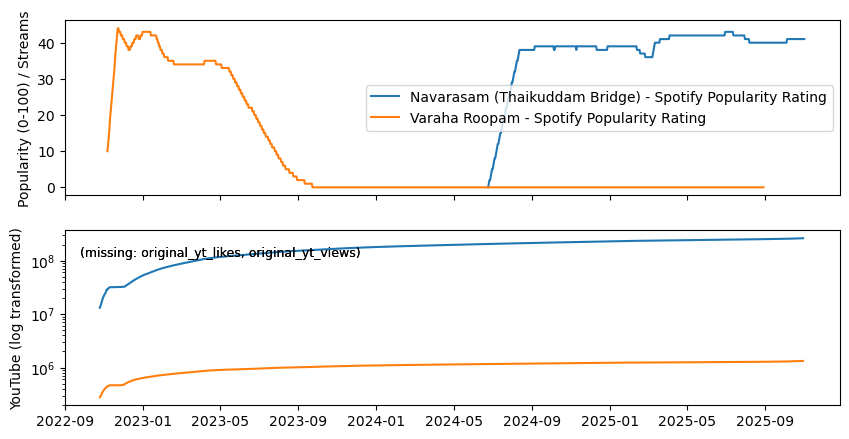

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

if {"original_sp_pop", "derived_sp_pop"}.issubset(full_data.columns):
    ax[0].plot(full_data["date"], full_data["original_sp_pop"], label="Navarasam (Thaikuddam Bridge) - Spotify Popularity Rating")
    ax[0].plot(full_data["date"], full_data["derived_sp_pop"], label="Varaha Roopam - Spotify Popularity Rating")
elif {"original_sp_streams", "derived_sp_streams"}.issubset(full_data.columns):
    ax[0].plot(full_data["date"], full_data["original_sp_streams"], label="Navarasam (Thaikuddam Bridge) - Spotify Popularity Rating")
    ax[0].plot(full_data["date"], full_data["derived_sp_streams"], label="Varaha Roopam - Spotify Popularity Rating")
ax[0].legend()
ax[0].set_ylabel("Popularity (0-100) / Streams")

yt_labels = {
    "original_yt_views": "Navarasam (Thaikkudam Bridge) - YT Views",
    "derived_yt_views": "Varaha Roopam - YT Views", 
    "original_yt_likes": "Original - YT Likes",
    "derived_yt_likes": "Derived - YT Likes"
}

have = [c for c in yt_labels if c in full_data.columns]

if have:
    for c in have:
        ax[1].plot(full_data["date"], full_data[c], label=yt_labels[c])
        ax[1].set_ylabel("YouTube (log transformed)")
        ax[1].set_yscale("log")
        missing = sorted(set(yt_labels).difference(have))
        if missing:
            ax[1].text(0.02, 0.85, "(missing: " + ", ".join(missing) + ")", transform=ax[1].transAxes, fontsize=9)
else:
    ax[1].text(0.02, 0.85, "(No YouTube series found)", transform=ax[1].transAxes, fontsize=9)

In [82]:
fig.suptitle(f"{pair_id} - Visibility Co-Movement")
result = fig_dir / f"{pair_id}_visibility_comovement.png"
if save_fig:
    fig.savefig(result, dpi=150)
    print("[SAVED]", result)
plt.show()

[SAVED] ../reports/visualizations/PAIR003_visibility_comovement.png
